In [2]:
import numpy as np
import scipy

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from matplotlib import animation 
    
from datetime import datetime
import time

In [90]:
class Evol:
    
    def maskFuncS32(self, x):
        if x >= -self.R and x <= -self.R+self.deltaM:
            return -2/self.deltaM**3 * (x+self.R-self.deltaM)**3 \
                   - 3/self.deltaM**2 * (x+self.R-self.deltaM)**2 + 1
        
        elif x >= self.R-self.deltaM and x <= self.R:
            return 2/self.deltaM**3 * (x-self.R+self.deltaM)**3 \
                   - 3/self.deltaM**2 * (x-self.R+self.deltaM)**2 + 1
        
        elif x > -self.R+self.deltaM and x < self.R-self.deltaM:
            return 1.0
        
        else:
            return 0.0
    
    def maskExp(self, x):
        return np.exp(-(x/(self.R-self.deltaM))**10)
    
    def __init__(self, R, M, deltaM, tau):
        self.R = R
        self.M = M
        self.tau = tau
        self.deltaM = deltaM
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        self.psi0 = np.exp(-self.x[1:-1]**2/4) / (2*np.pi)**(1/4)
        
        # matrix
        diagT = 2/self.delta**2 * np.ones(M-1)
        subdiagT = -1/self.delta**2 * np.ones(M-2)
        diagsT = [subdiagT, diagT, subdiagT]
        self.T = scipy.sparse.diags(diagsT,[-1,0,1]).toarray()
        self.expiTtau = scipy.linalg.expm(- 1j*self.T*self.tau)

        
        # mask
        self.mask = np.array([self.maskExp(self.x[1:-1][i]) for i in range(len(self.x[1:-1]))]) 
    
    def solver(self, nIter):
        psiM = self.mask * self.psi0
        psiMn = []
        for i in range(nIter):
            psiMn += [psiM]
            psiM = self.mask * (self.expiTtau @ psiM)
        
        return psiMn
    
    def solverRK(self, nIter):
        psiPrev = self.psi0
        psiSample = [psiPrev]
        for i in range(nIter):
            k1 = -1j * self.T @ psiPrev
            k2 = -1j * self.T @ (psiPrev + self.tau/2 * k1)
            k3 = -1j * self.T @ (psiPrev + self.tau/2 * k2)
            k4 = -1j * self.T @ (psiPrev + self.tau * k3)
            psiPrev = psiPrev + self.tau/6 * (k1 + 2*k2 + 2*k3 + k4)
            psiPrev = psiPrev * self.mask
            psiSample += [psiPrev]
        return psiSample
    
    def analiticSolution(self, nIter):
        return [np.exp(-self.x[1:-1]**2/(4*(1+1j*self.tau*i))) \
                / (2*np.pi)**(1/4) / np.sqrt(1+1j*self.tau*i) for i in range(nIter)]       

In [106]:
ev = Evol(10.0, 202, 0, 1e-1)

In [107]:
nIter = 100
psiRK = ev.solverRK(nIter)
psiAn = evRK.analiticSolution(nIter)
psiIt = ev.solver(nIter)

/tmp/ipykernel_6380/475735832.py:60: RuntimeWarning: invalid value encountered in multiply
  psiPrev = psiPrev + self.tau/6 * (k1 + 2*k2 + 2*k3 + k4)


<IPython.core.display.Javascript object>


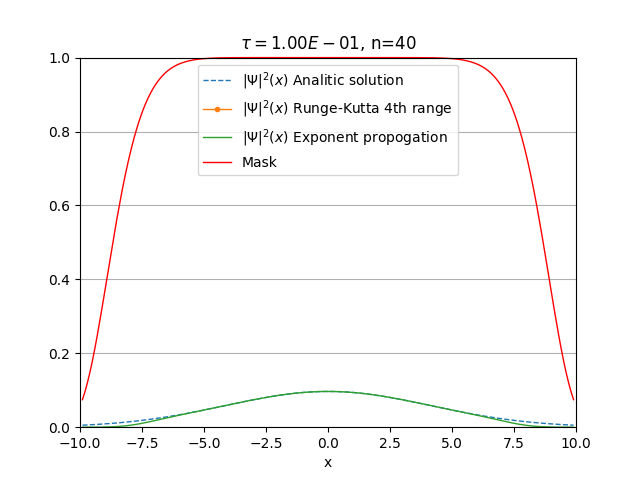

/tmp/ipykernel_6380/1249934315.py:26: RuntimeWarning: overflow encountered in square
  line2.set_data(ev.x[1:-1], np.absolute(psiRK[i])**2)


In [108]:
%matplotlib notebook 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-10, 10), ylim=(0, 1))
line1, = ax.plot([], [], lw=1, linestyle='--', label='$|\Psi|^2(x)$ Analitic solution')
line2, = ax.plot([], [], lw=1, marker='.', label=r'$|\Psi|^2(x)$ Runge-Kutta 4th range')
line3, = ax.plot([], [], lw=1, label=r'$|\Psi|^2(x)$ Exponent propogation')
line4, = ax.plot(ev.x[1:-1], evRK.mask, lw=1, c='red', label='Mask', clip_on=False)
ax.legend()
ax.grid(axis='y')
ax.set_xlabel('x')
# ax.set_ylabel()


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3,

# animation function.  This is called sequentially
def animate(i):
    line1.set_data(ev.x[1:-1], np.absolute(psiAn[i])**2)
    line2.set_data(ev.x[1:-1], np.absolute(psiRK[i])**2)
    line3.set_data(ev.x[1:-1], np.absolute(psiIt[i])**2)
    ax.set_title(fr'$\tau={ev.tau:>0.2E}$, n={i}')
    return line1, line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nIter, blit=True)

# # save the animation as an mp4.  This requires ffmpeg or mencoder to be
# # installed.  The extra_args ensure that the x264 codec is used, so that
# # the video can be embedded in html5.  You may need to adjust this for
# # your system: for more information, see
# # http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('figures/basic_animation.mp4', writer=animation.FFMpegWriter(fps=5))

plt.show()  